In [1]:
import sys
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import json
import pathlib

# modify the sys.path to include the source directory
src_dir = pathlib.Path().absolute().parent
sys.path.append(str(src_dir))

from src.enums import DataSplit
from src.utils.visualize import plot_images_and_bboxes
from src.data.bbox import BoundingBoxDetectionDataset
from src.enums import DataSplit
from src.utils.transforms import BBoxResize, BBoxBaseTransform, BBoxCompose, BBoxAnchorEncode
from src.utils.bbox import generate_anchores

In [2]:
DATASETS_ROOT = src_dir / 'datasets'
BATCH_SIZE = 3

transform = BBoxCompose([BBoxBaseTransform(), BBoxResize((360, 360))])
dataset = BoundingBoxDetectionDataset(root_dir=DATASETS_ROOT, split=DataSplit.TRAIN, transform=transform)

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

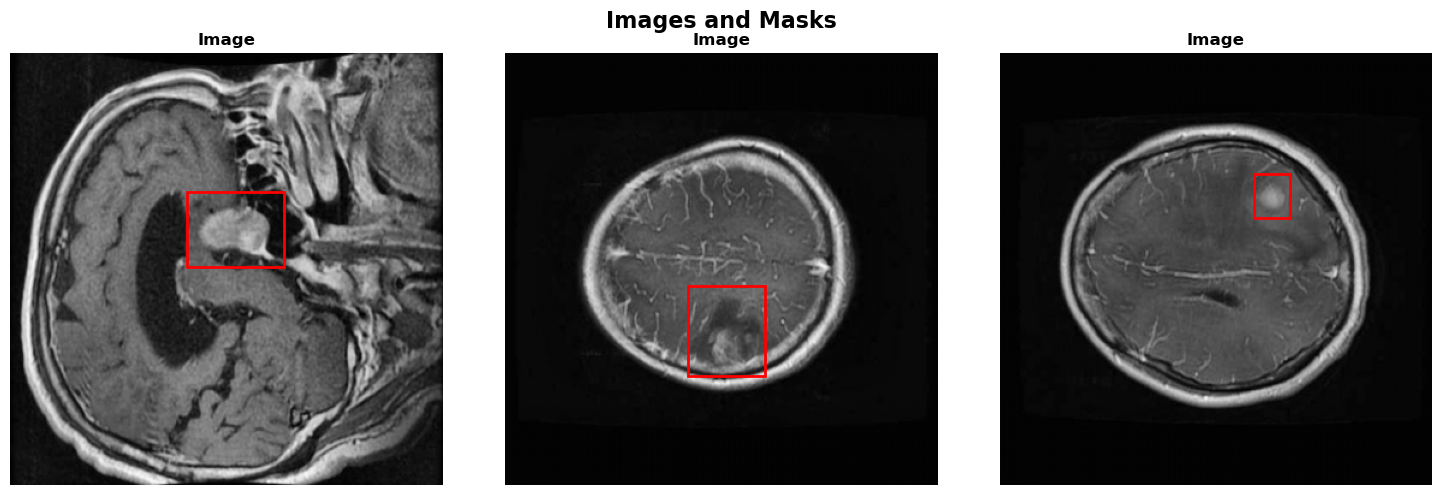

In [3]:
images, bboxs = next(iter(data_loader))
plot_images_and_bboxes(images, bboxs)

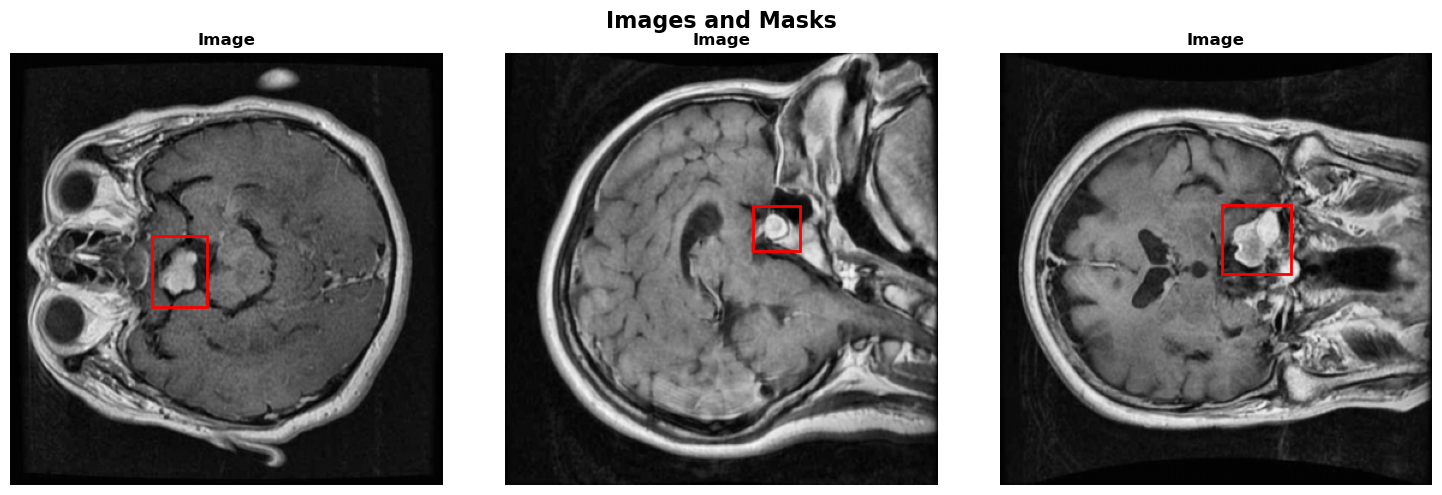

In [4]:
images, bboxs = next(iter(data_loader))
plot_images_and_bboxes(images, bboxs)

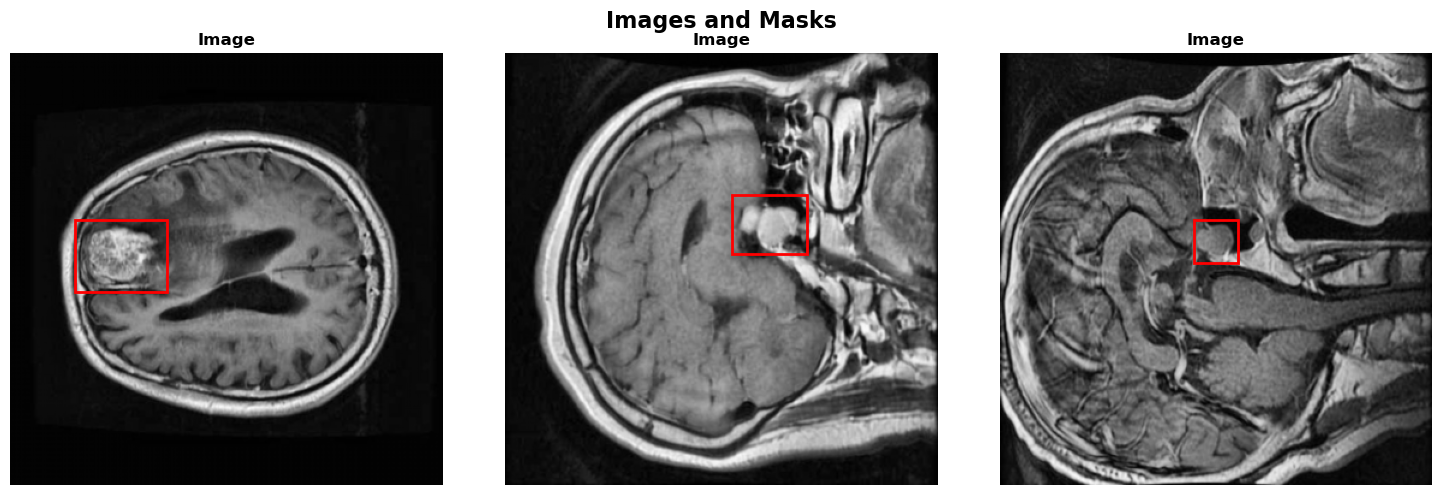

In [5]:
images, bboxs = next(iter(data_loader))
plot_images_and_bboxes(images, bboxs)

In [6]:
scales = [0.1, 0.175, 0.25, 0.3]
aspect_ratios = [1]
feature_map_size = 20
anchors, _ = generate_anchores(224, scales=scales, aspect_ratios=aspect_ratios, feature_map_size=feature_map_size)


transform = BBoxCompose([BBoxBaseTransform(), BBoxResize((224, 244)), BBoxAnchorEncode(anchors, 0.5, 0.3)])
dataset = BoundingBoxDetectionDataset(root_dir=DATASETS_ROOT, split=DataSplit.TRAIN, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

data_loader.dataset.image_id_to_bbox

{0: array([145.  , 239.  , 168.75, 162.5 ]),
 1: array([194.  , 176.  , 148.75, 233.75]),
 2: array([133. , 173. , 162.5, 185. ]),
 3: array([245.  , 358.  , 138.75, 166.25]),
 4: array([ 80. , 189. , 112.5, 132.5]),
 5: array([293. , 150. , 182.5, 135. ]),
 6: array([199.  , 165.  , 171.25, 133.75]),
 7: array([350. , 288. ,  42.5,  52.5]),
 8: array([239.  , 250.  ,  61.25,  87.5 ]),
 9: array([ 73.  , 139.  , 206.25, 166.25]),
 10: array([218.  , 225.  , 110.  ,  98.75]),
 11: array([283.  , 270.  , 111.25, 102.5 ]),
 12: array([148. , 216. , 225. , 182.5]),
 13: array([255.  , 173.  , 141.25, 162.5 ]),
 14: array([175.  , 159.  , 157.5 , 161.25]),
 15: array([114.  , 270.  , 141.25, 182.5 ]),
 16: array([279.  , 236.  ,  78.75,  76.25]),
 17: array([286.  , 160.  , 188.75, 166.25]),
 18: array([ 84.  , 239.  , 103.75, 107.5 ]),
 19: array([366.  , 226.  ,  70.  ,  66.25]),
 20: array([268. , 326. ,  82.5, 127.5]),
 21: array([115.  , 184.  , 208.75, 167.5 ]),
 22: array([194. , 249

In [7]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
images, (c, t) = next(iter(data_loader))

tensor(14)
tensor(14)
tensor([[ 74.7500, 116.5000,  36.7000,  39.6000],
        [ 74.7500, 116.5000,  36.7000,  39.6000],
        [ 74.7500, 116.5000,  36.7000,  39.6000],
        ...,
        [ 74.7500, 116.5000,  36.7000,  39.6000],
        [ 74.7500, 116.5000,  36.7000,  39.6000],
        [ 74.7500, 116.5000,  36.7000,  39.6000]])


In [8]:
for idx, (images, (c, t)) in enumerate(data_loader):
    if idx == 0:

    pass

tensor(13)
tensor(13)
tensor([[ 88.3500, 106.0500,  29.7000,  66.7000],
        [ 88.3500, 106.0500,  29.7000,  66.7000],
        [ 88.3500, 106.0500,  29.7000,  66.7000],
        ...,
        [ 88.3500, 106.0500,  29.7000,  66.7000],
        [ 88.3500, 106.0500,  29.7000,  66.7000],
        [ 88.3500, 106.0500,  29.7000,  66.7000]])
tensor(16)
tensor(16)
tensor([[69.4500, 95.6500, 34.5000, 48.1000],
        [69.4500, 95.6500, 34.5000, 48.1000],
        [69.4500, 95.6500, 34.5000, 48.1000],
        ...,
        [69.4500, 95.6500, 34.5000, 48.1000],
        [69.4500, 95.6500, 34.5000, 48.1000],
        [69.4500, 95.6500, 34.5000, 48.1000]])
tensor(12)
tensor(12)
tensor([[104.5000, 162.6000,  26.2000,  41.0000],
        [104.5000, 162.6000,  26.2000,  41.0000],
        [104.5000, 162.6000,  26.2000,  41.0000],
        ...,
        [104.5000, 162.6000,  26.2000,  41.0000],
        [104.5000, 162.6000,  26.2000,  41.0000],
        [104.5000, 162.6000,  26.2000,  41.0000]])
tensor(7)
tensor

In [11]:
import torch
images, (c, t) = next(iter(data_loader))
print(images)
non_zero_indices = torch.nonzero(c, as_tuple=True)[1]
print(non_zero_indices)
print(c[0][non_zero_indices])
t[0][non_zero_indices]

tensor([[[[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],

         [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]],

         [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0118, 0.0118,  ..., 0

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]])

In [10]:
anchors.shape

(1600, 4)